In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def tokenize_code_line(line):
    line = re.sub(r'//.*', '', line)
    line = re.sub(r'/\*.*?\*/', '', line)
    tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];,.=<>!+\-*/&|^%#~?:]', line)
    return tokens

In [4]:
vocab_counter = Counter()
all_tokens = []
dataset_path = "linux_input.txt"

In [5]:
with open(dataset_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        tokens = tokenize_code_line(line.strip())
        vocab_counter.update(tokens)
        all_tokens.extend(tokens)

In [17]:
vocab = sorted(vocab_counter.keys())
vocab_size = len(vocab)
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for token, idx in token_to_id.items()}


print(f"Vocabulary size (with <unk>): {vocab_size}")


print(f"Vocabulary size: {vocab_size}")

Vocabulary size (with <unk>): 35833
Vocabulary size: 35833


In [7]:
print("10 most frequent tokens:", vocab_counter.most_common(10))
print("10 least frequent tokens:", vocab_counter.most_common()[-10:])


10 most frequent tokens: [(')', 83714), ('(', 83598), (';', 77870), ('*', 72214), (',', 54287), ('-', 44389), ('=', 39595), ('>', 36911), ('.', 27385), ('}', 19182)]
10 least frequent tokens: [('trace_user_enter', 1), ('OTOH', 1), ('vtime', 1), ('entrancy', 1), ('vtime_user_exit', 1), ('trace_user_exit', 1), ('CONTEXT_KERNEL', 1), ('TIF', 1), ('CONFIG_CONTEXT_TRACKING_FORCE', 1), ('context_tracking_init', 1)]


In [8]:
context_window = 12

In [9]:
token_ids = torch.tensor([token_to_id[t] for t in all_tokens], dtype=torch.long)
num_samples = len(token_ids) - context_window
X = torch.stack([token_ids[i:i+context_window] for i in range(num_samples)])
y = token_ids[context_window:]

In [10]:
dataset = TensorDataset(X, y)
batch_size = 1024
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

In [11]:
class MLPCodeGen(nn.Module):
    def __init__(self, vocab_size, context_window=12, embedding_dim=32, hidden_size=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_window * embedding_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.Tanh()
        self.drop = nn.Dropout(0.37)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(embeds.size(0), -1)
        hidden = self.drop(self.act(self.fc1(embeds)))
        hidden = self.drop(self.act(self.fc2(hidden)))
        logits = self.out(hidden)
        return logits

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPCodeGen(vocab_size, context_window,32).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch 1/20 | Train Loss: 4.6078 | Val Loss: 3.9872 | Val Acc: 0.3685
Epoch 2/20 | Train Loss: 3.9043 | Val Loss: 3.7410 | Val Acc: 0.4004
Epoch 3/20 | Train Loss: 3.6079 | Val Loss: 3.6158 | Val Acc: 0.4165
Epoch 4/20 | Train Loss: 3.4039 | Val Loss: 3.5455 | Val Acc: 0.4323
Epoch 5/20 | Train Loss: 3.2490 | Val Loss: 3.5008 | Val Acc: 0.4410
Epoch 6/20 | Train Loss: 3.1283 | Val Loss: 3.4654 | Val Acc: 0.4485
Epoch 7/20 | Train Loss: 3.0310 | Val Loss: 3.4497 | Val Acc: 0.4530
Epoch 8/20 | Train Loss: 2.9495 | Val Loss: 3.4400 | Val Acc: 0.4573
Epoch 9/20 | Train Loss: 2.8793 | Val Loss: 3.4249 | Val Acc: 0.4616
Epoch 10/20 | Train Loss: 2.8184 | Val Loss: 3.4259 | Val Acc: 0.4653
Epoch 11/20 | Train Loss: 2.7668 | Val Loss: 3.4242 | Val Acc: 0.4675
Epoch 12/20 | Train Loss: 2.7204 | Val Loss: 3.4238 | Val Acc: 0.4712
Epoch 13/20 | Train Loss: 2.6793 | Val Loss: 3.4224 | Val Acc: 0.4715
Epoch 14/20 | Train Loss: 2.6411 | Val Loss: 3.4358 | Val Acc: 0.4760
Epoch 15/20 | Train Loss: 2.6

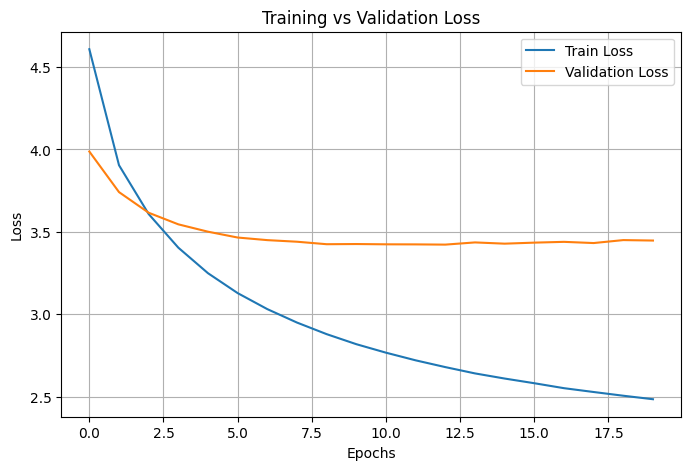

Final Validation Loss: 3.4471
Final Validation Accuracy: 48.33%


In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")

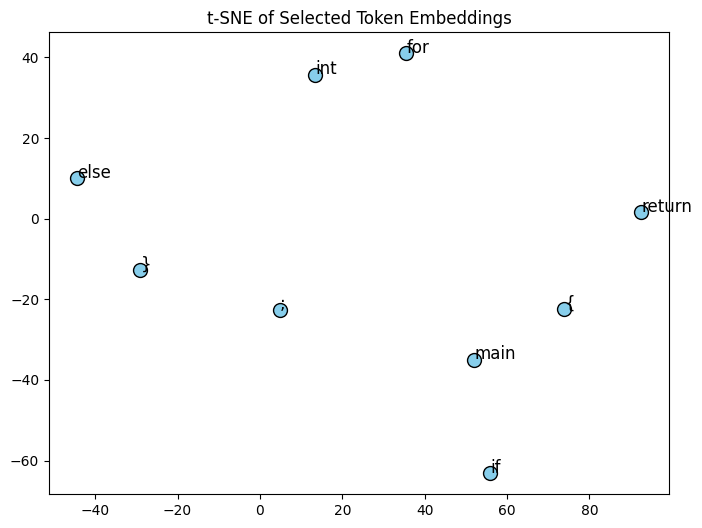

In [15]:
from sklearn.manifold import TSNE

code_vocab_data = torch.load("vocab_dicts.pth", map_location="cpu")
code_token_to_id = code_vocab_data["token_to_id"]

selected_tokens = ["int", "main", "return", "if", "else", "for", "{", "}", ";"]
subset_indices = [code_token_to_id[w] for w in selected_tokens if w in code_token_to_id]

subset_embeddings = model.embedding.weight[subset_indices].detach().cpu().numpy()

reduced = TSNE(n_components=2, perplexity=3, random_state=42).fit_transform(subset_embeddings)

# Step 5: Plot
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c='skyblue', s=100, edgecolors='k')

for i, word in enumerate(selected_tokens):
    plt.text(reduced[i, 0]+0.1, reduced[i, 1]+0.1, word, fontsize=12)

plt.title("t-SNE of Selected Token Embeddings")
plt.show()


Ideally, semantically similar words would form clusters in the 2d t-sne graph. The opposite words would be far from each other. The embeddings of similar words would be very similar and hence they would be placed close to each other. 
In my model, the points appeared mostly randomly scattered. This might be due to the fact that model might not be trained long enough to capture semantic patterns. The embedding dimension or learning rate might be too low.

In [20]:
import torch.nn.functional as F

def tokenize_code_line(line):
    line = re.sub(r'//.*', '', line)
    line = re.sub(r'/\*.*?\*/', '', line)
    tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];,.=<>!+\-*/&|^%#~?:]', line)
    return tokens

def generate_code(model, start_text, token_to_id, id_to_token,
                  max_new_tokens=40, context_window=12,
                  temperature=1.0, approach="greedy", device="cpu"):
    model.eval()
    tokens = tokenize_code_line(start_text)
    context = [token_to_id.get(t, 0) for t in tokens]


    generated = tokens.copy()

    for _ in range(max_new_tokens):
        x = context[-context_window:]
        if len(x) < context_window:
            x = [0] * (context_window - len(x)) + x
        x_tensor = torch.tensor([x], dtype=torch.long).to(device)

        with torch.no_grad():
            logits = model(x_tensor)[0] / temperature
            probs = F.softmax(logits, dim=-1)

            if approach == "greedy":
                next_id = torch.argmax(probs).item()
            else:
                next_id = torch.multinomial(probs, 1).item()

        next_token = id_to_token.get(next_id, "<unk>")
        generated.append(next_token)

        if next_token == "<eos>":
            generated.pop()
            break

        context.append(next_id)

    return " ".join(generated)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLPCodeGen(vocab_size=len(token_to_id), context_window=12, embedding_dim=32).to(device)
model.load_state_dict(torch.load("model_12_emb32_tanh.pth", map_location=device))

user_input = input("Enter your starting code: ")
generated_text = generate_code(model, user_input, token_to_id, id_to_token,
                               max_new_tokens=40, context_window=12,
                               temperature=1.0, approach="greedy", device=device)

print("\nGenerated code prediction:\n")
print(generated_text)



Generated code prediction:

if ( x = = ) ) return ; if ( ! ( time_status & STA_NANO ) ) return - EINVAL ; } if ( ! ( ( desc - > irq_data ) ) ) return ; if ( desc - > irq_data . chip


The model takes input from the user and predicts the next few tokens based on the input. However, the predicted tokens are not very accurate because the model is trained on relatively smaller dataset.

Dataset & Vocabulary:
Natural language has a large, much larger vocabulary which makes it harder to predict.
Code has limited, repetitive tokens and strict syntax hence it becomes easier to model.

Model Performance:
Code model shows faster loss convergence and better accuracy due to structure.
Natural language model learns much slower.

Embeddings:
Word embeddings form loose semantic clusters.
Code embeddings group tightly by syntax .

Insights:
Structured language (code) is more learnable and predictable due to strict syntax.
Natural language is difficult to predict due to semanticity.